In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2, os

from functools import reduce

(720, 1280)


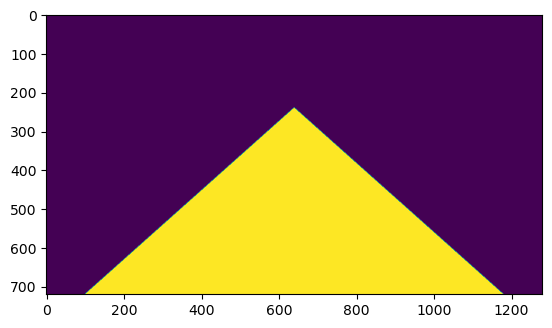

In [6]:
DEFAULT_SEG_CRT = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

def create_triangle_mask(width, height):
  """Creates a triangular mask of the specified size.

  Args:
    width: Width of the mask.
    height: Height of the mask.

  Returns:
    A numpy array representing the triangular mask.
  """

  mask = np.zeros((height, width), dtype=np.uint8)

  # Define the triangle vertices
  pt1 = (0, height)
  pt2 = (width, height)
  pt3 = (width // 2, 0)

  # Create a filled triangle
  cv2.fillConvexPoly(mask, np.array([pt1, pt2, pt3], dtype=np.int32), 255)

  return mask

def pad_image(img, top, bottom, left, right, borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0]):
  """Pads an image with zeros.

  Args:
    img: The input image.
    top, bottom, left, right: The amount of padding to add in each direction.
    borderType: The type of border.
    value: The value to fill the border with (default is black).

  Returns:
    The padded image.
  """

  return cv2.copyMakeBorder(img, top, bottom, left, right, borderType, value=value)

WIDTH = 1280
HEIGHT = 720
MASK_TRIANGLE_WIDTH = 1080
MASK_TRIANGLE_HEIGHT = 480
FRONT_MASK_01 = pad_image(create_triangle_mask(MASK_TRIANGLE_WIDTH, MASK_TRIANGLE_HEIGHT), HEIGHT - MASK_TRIANGLE_HEIGHT, 0, (WIDTH - MASK_TRIANGLE_WIDTH) // 2, (WIDTH - MASK_TRIANGLE_WIDTH) // 2)
print(FRONT_MASK_01.shape)
plt.imshow(FRONT_MASK_01)

def mask_image(image, mask):
    return cv2.bitwise_and(image, image, mask=mask)


def kmeans_segmentation(image, attempts = 10, k = 4, criteria = DEFAULT_SEG_CRT):
    td_img = np.float32(image.reshape((-1, 3)))
    _, label, center = cv2.kmeans(td_img, k, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)

    center = np.uint8(center)
    res = center[label.flatten()]

    return res.reshape((image.shape))


def detect_color_profile(image, lower_bound, upper_bound, blur_image = False):
    if blur_image is True:
        image = cv2.GaussianBlur(image, (5, 5), 0)
    color_mask = cv2.inRange(image, lower_bound, upper_bound)
    return cv2.bitwise_and(image, image, mask=color_mask)


WODEN_FENCE_OBSTACLE_LOWER = np.array([  5,   47, 99])
WODEN_FENCE_OBSTACLE_HIGHER = np.array([ 40, 255, 213])
PLANT_BASE_OBSTACLE_LOWER = np.array([  34,   0, 95])
PLANT_BASE_OBSTACLE_HIGHER = np.array([ 85, 38, 195])

def detect_woden_fence_obstacle(image, lower_adjust = 0, upper_adjust = 0, image_is_hsv = False):
    if not image_is_hsv:
        image = convert_image_to_hsv(image)
    return detect_color_profile(
        image=image,
        lower_bound=np.array(WODEN_FENCE_OBSTACLE_LOWER) + lower_adjust,
        upper_bound=np.array(WODEN_FENCE_OBSTACLE_HIGHER) + upper_adjust,
        blur_image=False,
    )

def detect_plant_base_obstacle(image, lower_adjust = 0, upper_adjust = 0, image_is_hsv = False):
    if not image_is_hsv:
        image = convert_image_to_hsv(image)
    return detect_color_profile(
        image=image,
        lower_bound=np.array(PLANT_BASE_OBSTACLE_LOWER) + lower_adjust,
        upper_bound=np.array(PLANT_BASE_OBSTACLE_HIGHER) + upper_adjust,
        blur_image=False,
    )

def convert_image_to_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV_FULL)


def canny(image, thresh1 = 50, thresh2 = 100, blur_image = False):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    if blur_image is True:
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

    return cv2.Canny(gray, thresh1, thresh2)


def make_coordinates(image, line_params):
    slope, intercept = line_params
    y1 = image.shape[0]
    y2 = int(y1 * 0.8)
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])


def average_slope_intercep(image, lines):
    left_fit = []
    right_fit = []
    for x1, y1, x2, y2 in lines.reshape(-1, 4):
        params = np.polyfit((x1, x2), (y1, y2), 1)
        slope = params[0]
        intercept = params[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    left_fit_average = np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis=0)
    left_line = make_coordinates(image, left_fit_average)
    right_line = make_coordinates(image, right_fit_average)
    return np.array([left_line, right_line])


def hough_lines(image, min_line_len = 20, max_line_gap = 20, image_is_canny = False):
    if not image_is_canny:
        image = canny(image, blur_image = True)
    return cv2.HoughLinesP(image, 2, np.pi / 180, 10, np.array([]), min_line_len, max_line_gap)


def draw_lines_on_image(image, lines, color_rgb = (255, 0, 0)):
    line_image = np.zeros_like(image)

    if lines is not None:
        for x1, y1, x2, y2 in lines.reshape(-1, 4):
            cv2.line(line_image, (x1, y1), (x2, y2), color_rgb, 10)

    return cv2.addWeighted(image, 0.8, line_image, 1, 1)

In [7]:
def line_dist_to_point(line, point):
    x1, y1, x2, y2 = line
    x0, y0 = point
    mod = np.abs((x2 - x1) * (y1 - y0) - (x1 - x0) * (y2 - y1))
    ro = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return mod / ro


def point_distance(x0, y0, x1, y1):
    return np.sqrt((x1 - x0)**2 + (y1 - y0)**2)


def closest_point(point, other_points):
    result = None
    x0, y0 = point
    for other_point in other_points:
        x1, y1 = other_point
        d = point_distance(x0, y0, x1, y1)
        if result is None or d < result[-1]:
            result = [np.array((x1, y1)), d]
    return result


def weighted_line_dist_to_point(line, point):
    line_dist = line_dist_to_point(line, point)
    _, inverse_weight = closest_point(point, line.reshape(2, 2))
    return line_dist / inverse_weight


def define_line_reducer_on_point(point):
    def reducer(a, b):
        _, dist_a = closest_point(point, a.reshape(2, 2))
        _, dist_b = closest_point(point, b.reshape(2, 2))
        return a if dist_a < dist_b else b
    return reducer

In [10]:
img_path = '/home/rs2lab/ros2_ws/src/parc24-agribot/captured_images/front/'
front = cv2.cvtColor(cv2.imread(os.path.join(img_path, "front_image_10.png")), cv2.COLOR_BGR2RGB)
front_hsv = cv2.cvtColor(front, cv2.COLOR_RGB2HSV)

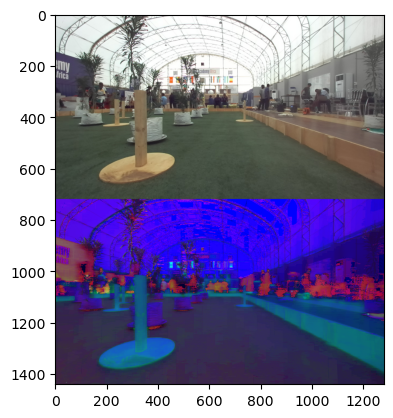

In [12]:
plt.imshow(np.vstack([front, front_hsv]))

In [21]:
wooden_detection = detect_woden_fence_obstacle(front_hsv, image_is_hsv=True)
plant_base_detection = detect_plant_base_obstacle(front_hsv, image_is_hsv=True)
woden_lines = hough_lines(mask_image(wooden_detection, FRONT_MASK_01))
plant_base_lines = hough_lines(mask_image(plant_base_detection, FRONT_MASK_01))

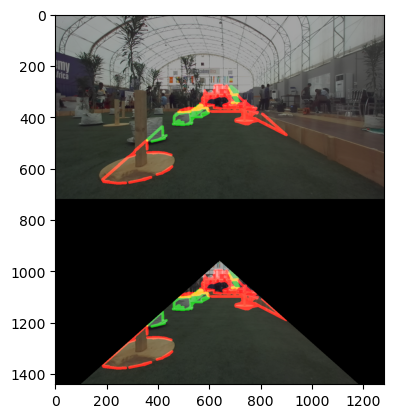

In [22]:
final = draw_lines_on_image(
    draw_lines_on_image(front, plant_base_lines, color_rgb=(0, 255, 0)),
    woden_lines)
plt.imshow(np.vstack([final, mask_image(final, FRONT_MASK_01)]))

In [23]:
front_right_line_reducer = define_line_reducer_on_point([910, 1080])
front_left_line_reducer = define_line_reducer_on_point([370, 1080])

In [24]:
closest_front_left_plant_base_line = reduce(front_left_line_reducer, plant_base_lines.reshape(-1, 4))
closest_front_right_plant_base_line = reduce(front_right_line_reducer, plant_base_lines.reshape(-1, 4))
closest_front_left_woden_line = reduce(front_left_line_reducer, woden_lines.reshape(-1, 4))
closest_front_right_woden_line = reduce(front_left_line_reducer, woden_lines.reshape(-1, 4))

In [25]:
front_left_lines = np.hstack((closest_front_left_plant_base_line, closest_front_left_woden_line)).reshape(-1, 1, 4)
front_right_lines = np.hstack((closest_front_right_plant_base_line, closest_front_right_woden_line)).reshape(-1, 1, 4)

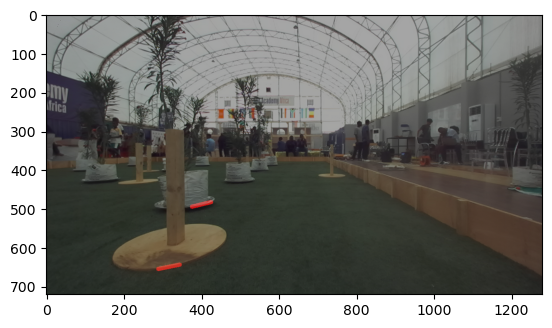

In [29]:
front_image = draw_lines_on_image(draw_lines_on_image(front, front_left_lines), front_right_lines, color_rgb=(0, 255, 0))
plt.imshow(front_image)

In [117]:
def theta_transfer_function_rev(closest_front_left_line, closest_front_right_line):
    (xl, yl), dl = closest_point(FRONT_VISION_LEFT_POINT, closest_front_left_line.reshape(2, 2))
    (xr, yr), dr = closest_point(FRONT_VISION_RIGHT_POINT, closest_front_right_line.reshape(2, 2))
    # NOTE: This is the first one I though of, but it isn't a good function because this way the rotation
    # will increase with the decrease of the distance between the left and right point, which is not
    # good since that means the we have less space between the points, therefore, less rotation would
    # be better for this situation.
    return (np.pi / 2) * np.tanh((dl - dr) / point_distance(xl, yl, xr, yr))

def theta_transfer_function_log(closest_front_left_line, closest_front_right_line):
    (xl, yl), dl = closest_point(FRONT_VISION_LEFT_POINT, closest_front_left_line.reshape(2, 2))
    (xr, yr), dr = closest_point(FRONT_VISION_RIGHT_POINT, closest_front_right_line.reshape(2, 2))
    # NOTE: this is the one I am choosing to use right now because it haves a best relation with the
    # distance of the two (left, and right) points and the rotation, so that, if we have more distance, we
    # will have a smaller rotation.
    dist = point_distance(xl, yl, xr, yr)
    dist = np.log(dist) if dist > 3 else dist
    return (np.pi / 2) * np.tanh(dist / (dl - dr))

In [118]:
ll = closest_front_left_plant_line
# Here we shift the right line to a close position to the left, so that we can
# see what I said before in the functions.
rr = closest_front_right_plant_line - (100, 0, 100, 0)

theta_transfer_function_rev(ll, rr), theta_transfer_function_log(ll, rr)

(-0.4688257910317305, -0.13513581303596003)